# Проверка гипотез для увеличения выручки интернет-магазина

## Описание данных

Для работы нам доступно три датасета:
1) Файл `/datasets/hypothesis.csv`
 - `Hypothesis` — краткое описание гипотезы;
 - `Reach` — охват пользователей по 10-балльной шкале;
 - `Impact` — влияние на пользователей по 10-балльной шкале;
 - `Confidence` — уверенность в гипотезе по 10-балльной шкале;
 - `Efforts` — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.
 
Он содержит 9 гипотез по увеличению выручки интернет-магазина с вышеуказанными параметрами.
Для приоритезации гипотез используем фреймворк `ICE`, а так же фреймворк `RICE`, и выясним причину отличия в результатах.
 
2) Файл `/datasets/orders.csv`
 - `transactionId` — идентификатор заказа;
 - `visitorId` — идентификатор пользователя, совершившего заказ;
 - `date` — дата, когда был совершён заказ;
 - `revenue` — выручка заказа;
 - `group` — группа A/B-теста, в которую попал заказ.

3) Файл `/datasets/visitors.csv`
 - `date` — дата;
 - `group` — группа A/B-теста;
 - `visitors` — количество пользователей в указанную дату в указанной группе A/B-теста.
 
 В данных файлах содержатся результаты проведенного ранее A/B-теста.
 
Для анализа и принятие решения по результатам теста будет необходимо построить множество графиков, таких как:
 - График кумулятивной выручки и кумулятивного среднего чека по группам;
 - График относительного изменения кумулятивного среднего чека группы B к группе A;
 - График кумулятивного среднего количества заказов на посетителя по группам;
 - График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A;
 - Точечный график количества заказов по пользователям;
 - Точечный график стоимостей заказов.
 
Так же будет произведен расчет 95-го и 99-го перцентилей количества заказов на пользователя и стоимости заказов.
Завершит анализ просчет статистической значимости различий в среднем количестве заказов на посетителя и чеке заказа между группами по «сырым» данным, а затем те же самые показатели по "очищенным данным".

На основе полученных выводов можно будет принять окончательное решение по результатам теста, например:
- Остановить тест, зафиксировать победу одной из групп.
- Остановить тест, зафиксировать отсутствие различий между группами.
- Продолжить тест.

## Предобработка данных

Перед началом работы загрузим необходимые для работы библиотеки:

In [1]:
import pandas as pd
import scipy.stats as stats
import datetime as dt
import numpy as np
from matplotlib import pyplot as plt
from pandas.plotting import register_matplotlib_converters
import warnings
register_matplotlib_converters()

А так же загрузим данные из csv-файлов в датафреймы, сохраним в переменные hypothesis, orders, visitors и изучим первые 10 строк каждой таблицы:

In [2]:
hypothesis, orders, visitors = ( #читаем csv-файлы и сохраняем в переменные с данными
    pd.read_csv('/datasets/hypothesis.csv'),  #журнала гипотез
    pd.read_csv('/datasets/orders.csv'),  #заказов
    pd.read_csv('/datasets/visitors.csv'))   #пользователей

In [3]:
display(hypothesis.head(10))
display(orders.head(10))
visitors.head(10)
#выведем первые 10 значений

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3
6,Показать на главной странице баннеры с актуаль...,5,3,8,3
7,Добавить форму подписки на все основные страни...,10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B
6,398296753,2900797465,2019-08-15,1860,B
7,2626614568,78758296,2019-08-15,1044,A
8,1576988021,295230930,2019-08-15,13710,A
9,1506739906,1882260405,2019-08-15,1855,B


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
5,2019-08-06,A,667
6,2019-08-07,A,644
7,2019-08-08,A,610
8,2019-08-09,A,617
9,2019-08-10,A,406


Видим, что название колонок первых двух датасетов заведены не соответсвующе змеиному регистру, исправим это:

In [4]:
orders.columns = orders.columns.str.replace('I', '_i')
#сначала перименуем столбцы с двумя словами в датафрейме orders
hypothesis.columns = hypothesis.columns.str.lower()
#затем приводим все столбцы в датафрейме hypothesis в нижний регистр
display(hypothesis.head(10))
display(orders.head(10))
visitors.head(10)
#проверим изменения

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3
6,Показать на главной странице баннеры с актуаль...,5,3,8,3
7,Добавить форму подписки на все основные страни...,10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5


,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B
6,398296753,2900797465,2019-08-15,1860,B
7,2626614568,78758296,2019-08-15,1044,A
8,1576988021,295230930,2019-08-15,13710,A
9,1506739906,1882260405,2019-08-15,1855,B


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
5,2019-08-06,A,667
6,2019-08-07,A,644
7,2019-08-08,A,610
8,2019-08-09,A,617
9,2019-08-10,A,406


Таблицы выглядят корректно и мы можем ознакомиться с основной информацией датафреймах:

In [5]:
hypothesis.info()
orders.info()
visitors.info()
#выводим информацию о датафрейме

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   hypothesis  9 non-null      object
 1   reach       9 non-null      int64 
 2   impact      9 non-null      int64 
 3   confidence  9 non-null      int64 
 4   efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   transaction_id  1197 non-null   int64 
 1   visitor_id      1197 non-null   int64 
 2   date            1197 non-null   object
 3   revenue         1197 non-null   int64 
 4   group           1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns)

На основе вышеуказанных данных можно сделать несколько выводов:
1) Ни один из датафреймов не содержит пустых значений

2) Требуется преобразовать данные о времени, остальные данные соответствуют типу

In [6]:
orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
visitors['date'] = visitors['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
#преобразовали все столбцы с датами 
hypothesis.info()
orders.info()
visitors.info()
#снова выводим данные для проверки

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   hypothesis  9 non-null      object
 1   reach       9 non-null      int64 
 2   impact      9 non-null      int64 
 3   confidence  9 non-null      int64 
 4   efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   transaction_id  1197 non-null   int64         
 1   visitor_id      1197 non-null   int64         
 2   date            1197 non-null   datetime64[ns]
 3   revenue         1197 non-null   int64         
 4   group           1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB
<class 'pandas.core.frame

Осталось проверить датафреймы на наличие явных дубликатов:

In [7]:
display(hypothesis.duplicated().sum())
display(orders.duplicated().sum())
visitors.duplicated().sum()
#выводим подсчитанное количество дубликатов

0

0

0

И неявных:

In [8]:
display(visitors['group'].unique())
orders['group'].unique()
#проверяем не отличаются ли уникальные значения в столбцах с типом object

array(['A', 'B'], dtype=object)

array(['B', 'A'], dtype=object)

**Вывод:** В ходе предобработки данных названия столбцов датафрема были приведены в "змеиный" регистр, столбцы, содержащие дату, были приведены в соответствующий тип данных и так же была осуществлена проверка на дубликаты и пустые значения.

## Приоритизация гипотез

### Фреймворк ICE

После того, как мы убедились, что данные заполнены корректно можем приступить к приоритезации гипотез, т.к. проверка гипотез чаще всего стоит дорого, а ресурсов не хватает. Придётся выбрать, что будем тестировать, а чему скажем «нет». 

In [9]:
hypothesis['ice'] = round((hypothesis['impact'] * hypothesis['confidence'])/hypothesis['efforts'],1)
#создаем дополнительный столбец с расчетом ice
ice_hypothesis = hypothesis[['hypothesis','ice']].sort_values(by='ice', ascending=False)
#создаем переменную, в которую войдут только гипотезы и новый столбец, затем сортируем по убывнию столбца ice
display(ice_hypothesis)
#вывдедем результат на экран
top_ice_hypothesis = ice_hypothesis['hypothesis'].head(3).unique()
top_ice_hypothesis
#для прочтения полного текста первых 3-х гипотез выведем уникальные значения из столбца гипотез

,hypothesis,ice
8,"Запустить акцию, дающую скидку на товар в день...",16.2
0,"Добавить два новых канала привлечения трафика,...",13.3
7,Добавить форму подписки на все основные страни...,11.2
6,Показать на главной странице баннеры с актуаль...,8.0
2,Добавить блоки рекомендаций товаров на сайт ин...,7.0
1,"Запустить собственную службу доставки, что сок...",2.0
5,"Добавить страницу отзывов клиентов о магазине,...",1.3
3,"Изменить структура категорий, что увеличит кон...",1.1
4,"Изменить цвет фона главной страницы, чтобы уве...",1.0


array(['Запустить акцию, дающую скидку на товар в день рождения',
       'Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей',
       'Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок'],
      dtype=object)

Наиболее перспективные гипотезы по ICE: 
9.Запустить акцию, дающую скидку на товар в день рождения;

1.Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей;

8.Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок. 

Проверим какой результат получится при использовании RICE:

### Фреймворк RICE

In [10]:
hypothesis['rice'] = (hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence'])/hypothesis['efforts']
#создаем дополнительный столбец с расчетом rice
rice_hypothesis = hypothesis[['hypothesis','rice']].sort_values(by='rice', ascending=False)
#создаем переменную, в которую войдут только гипотезы и новый столбец, затем сортируем по убывнию столбца rice
display(rice_hypothesis)
#вывдедем результат на экран
top_rice_hypothesis = rice_hypothesis['hypothesis'].head(4).unique()
top_rice_hypothesis
#для прочтения полного текста первых 4-х гипотез выведем уникальные значения из столбца гипотез

,hypothesis,rice
7,Добавить форму подписки на все основные страни...,112.0
2,Добавить блоки рекомендаций товаров на сайт ин...,56.0
0,"Добавить два новых канала привлечения трафика,...",40.0
6,Показать на главной странице баннеры с актуаль...,40.0
8,"Запустить акцию, дающую скидку на товар в день...",16.2
3,"Изменить структура категорий, что увеличит кон...",9.0
1,"Запустить собственную службу доставки, что сок...",4.0
5,"Добавить страницу отзывов клиентов о магазине,...",4.0
4,"Изменить цвет фона главной страницы, чтобы уве...",3.0


array(['Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок',
       'Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа',
       'Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей',
       'Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию'],
      dtype=object)

При использовании модели RICE абсолютным лидером стала 8 гипотеза(Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок), а так же в приоритете:

  3.Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа;

  1.Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей;

  7.Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию.

**Вывод:** Такая разница в приоритезации гипотез вызвана тем, что добавление формы подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок охватывает гораздо большее количество пользователей, чем если запустить акцию, дающую скидку на товар в день рождения. Это связано с тем, что акция будет иметь ограничение временного характера, а значит будет предназначена для только для пользователей, которые вообще указали дату рождения (во многих сервисах это необязательное поле), и только для тех пользователей, у которых в месяц проведения акции будет день рождения. 

Выбор метрики зависит от того, важно ли нам, на какой охват пользователей повлияет та или иная гипотеза и есть ли возможность вообще этот охват оценить. Т.к. у нас такие данные имеются, предпочтительнее воспользоваться результатами приоритезации по модели RICE.

## Анализ A/B-теста

### График кумулятивной выручки по группам

Чтобы построить графики, нужно собрать кумулятивные данные в одну таблицу:

In [11]:
dates_groups = orders[['date','group']].drop_duplicates()
#создаем массив уникальных пар значений дат и групп теста

orders_agg = dates_groups.apply( 
    #cоберем агрегированные кумулятивные по дням данные о заказах
    lambda x: orders[
        np.logical_and(
            orders['date'] <= x['date'], orders['group'] == x['group']
        ) #получим строки таблицы orders, дата которых меньше или равна дате элемента из dates_groups, 
        #а группа теста равна группе из dates_groups
    ].agg(
        {
            'date': 'max', 
            'group': 'max', #вычислим максимальную дату и группу
            'transaction_id': 'nunique', 
            'visitor_id': 'nunique', #число уникальных ID заказов и пользователей
            'revenue': 'sum', #сумму средних чеков
        }
    ),
    axis=1, #применим методы к каждой строке датафрейма
).sort_values(by=['date', 'group']) #отсортируем результаты по столбцам


visitors_agg = dates_groups.apply(
    lambda x: visitors[
        np.logical_and(
            visitors['date'] <= x['date'], visitors['group'] == x['group']
        )
    ].agg({'date': 'max', 'group': 'max', 'visitors': 'sum'}),
    axis=1,
).sort_values(by=['date', 'group'])
#аналогично получим агрегированные кумулятивные по дням данные о посетителях интернет-магазина 


cmltv_data = orders_agg.merge(
    visitors_agg, left_on=['date', 'group'], right_on=['date', 'group']
)
#объединяем кумулятивные данные в одной таблице
cmltv_data.columns = [
    'date',
    'group',
    'orders',
    'buyers',
    'revenue',
    'visitors',
]
#присваиваем ее столбцам понятные названия

cmltv_data.head(5)
#проверяем, что у нас получилось

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845


С помощью собранных данных построим графики кумулятивной выручки по дням и группам A/B-тестирования:

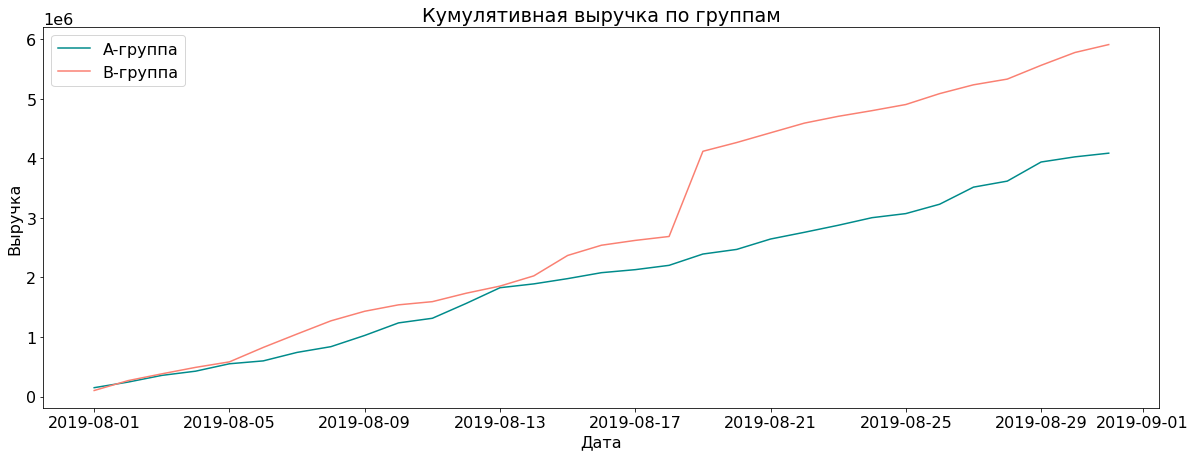

In [12]:
cmltv_rev_a = cmltv_data[cmltv_data['group']=='A'][['date','revenue', 'orders']]
#создаем датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А

cmltv_rev_b = cmltv_data[cmltv_data['group']=='B'][['date','revenue', 'orders']]
#и по группе B

plt.rcParams['font.size'] = 16 
#установим размер шрифта

plt.figure(figsize=(20,7))
#зададим размер графика

plt.plot(cmltv_rev_a['date'], cmltv_rev_a['revenue'], label='A-группа', color = 'darkcyan')
#строим график выручки группы А

plt.plot(cmltv_rev_b['date'], cmltv_rev_b['revenue'], label='B-группа', color = 'salmon')
#и группы B

plt.legend()
plt.xlabel('Дата')
plt.ylabel ('Выручка')
plt.title('Кумулятивная выручка по группам');
#оформляем 

Можно заметить, что в промежутке между 17 и 21 августа произошел резкий рост кумулятивной выручки в группе B, проверим причины данного роста:

In [13]:
display(cmltv_rev_b.query('date > "2019-08-16" and date < "2019-08-21"').sort_values(by='revenue'))
#сделаем срез по дате резкого увеличения значений группы B

,date,revenue,orders
33,2019-08-17,2620790,373
35,2019-08-18,2686621,382
37,2019-08-19,4116541,403
39,2019-08-20,4263815,423


**Вывод:** Выручка почти равномерно увеличивается в течение всего теста, однако графики выручки группы B в нескольких точках резко растет. Это может сигнализировать о всплесках числа заказов, либо о появлении очень дорогих заказов в выборке. После проверки методом среза, можно понять, что рост вызван резким увеличенем выручки заказов начиная с 19 августа 2019 года.

### График кумулятивного среднего чека по группам

Теперь можем построить графики среднего чека по группам — разделим кумулятивную выручку на кумулятивное число заказов:

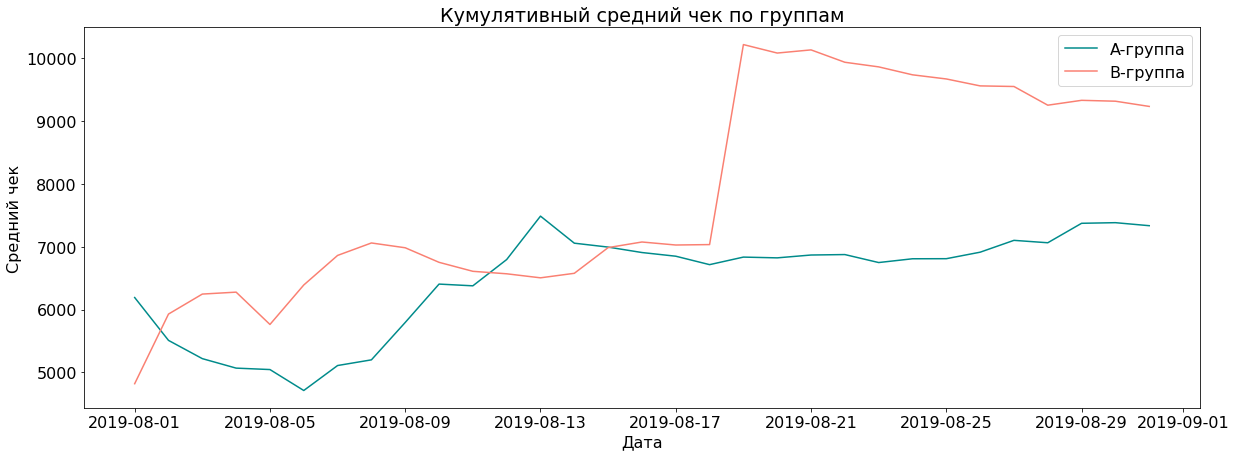

In [14]:
plt.figure(figsize=(20,7))
#зададим размер графика

plt.plot(cmltv_rev_a['date'], cmltv_rev_a['revenue']/cmltv_rev_a['orders'],\
         label='A-группа', color = 'darkcyan')
#строим график среднего чека группы А

plt.plot(cmltv_rev_b['date'], cmltv_rev_b['revenue']/cmltv_rev_b['orders'],\
         label='B-группа', color = 'salmon')
#и группы B

plt.legend()
plt.xlabel('Дата')
plt.ylabel ('Средний чек')
plt.title('Кумулятивный средний чек по группам');
#оформляем

**Вывод:** Средний чек для группы A сначала показывал снижение, после 6 августа начал расти, и стал относительно стабилен после резкого роста в 13-х числах августа. Для группы B характерен постоянный рост, кроеме "ямы" 5 августа и постепенного снижения после "пика" 19 августа. По итогу лучшие результаты по среднему чеку показывает группа B, хотя и имеет тенденцию к снижению.

### График относительного изменения кумулятивного среднего чека группы B к группе A

Для построения данного графика требуется объеденить кумулятивные данные по группам:

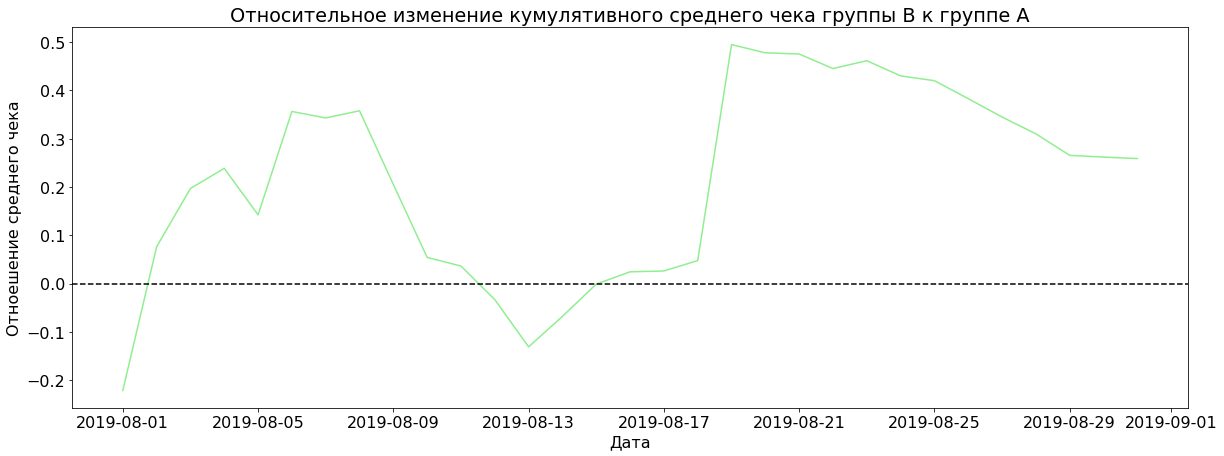

In [15]:
cmltv_rev = cmltv_rev_a.merge(cmltv_rev_b, left_on='date', right_on='date', how='left', suffixes=['_a', '_b'])
#объединяем данные в одном датафрейме

plt.figure(figsize=(20,7))
#зададим размер графика

plt.plot(cmltv_rev_a['date'],(cmltv_rev['revenue_b']/cmltv_rev['orders_b'])\
         /(cmltv_rev['revenue_a']/cmltv_rev['orders_a'])-1, color = 'lightgreen')
#строим график

plt.xlabel('Дата')
plt.ylabel ('Отноешение среднего чека')
plt.title('Относительное изменение кумулятивного среднего чека группы B к группе A')
#оформляем

plt.axhline(y=0, color='black', linestyle='--');
#добавляем горизонтальную ось

**Вывод:** 13 августа отношение среднего чека группы B к группе A единственый раз падает, не считая начала тестирования. В целом весь график имеет резкие скачки, а значит в данных присутствуют выбросы.

### График кумулятивного среднего количества заказов на посетителя по группам

Для построение данного графика посчитаем конверсию:

In [16]:
cmltv_data['conversion'] = cmltv_data['orders']/cmltv_data['visitors']
# считаем кумулятивную конверсию

cmltv_data_a = cmltv_data[cmltv_data['group']== 'A']
cmltv_data_b = cmltv_data[cmltv_data['group']== 'B']
# отделяем данные по группам

display(cmltv_data_a.head(10))
cmltv_data_b.head(10)
#выведем получившиеся данные

,date,group,orders,buyers,revenue,visitors,conversion
0,2019-08-01,A,24,20,148579,719,0.033380
2,2019-08-02,A,44,38,242401,1338,0.032885
4,2019-08-03,A,68,62,354874,1845,0.036856
6,2019-08-04,A,84,77,425699,2562,0.032787
8,2019-08-05,A,109,100,549917,3318,0.032851
10,2019-08-06,A,127,114,598401,3985,0.031870
12,2019-08-07,A,145,131,740818,4629,0.031324
14,2019-08-08,A,161,146,837097,5239,0.030731
16,2019-08-09,A,177,159,1025603,5856,0.030225
18,2019-08-10,A,193,175,1236098,6262,0.030821


,date,group,orders,buyers,revenue,visitors,conversion
1,2019-08-01,B,21,20,101217,713,0.029453
3,2019-08-02,B,45,43,266748,1294,0.034776
5,2019-08-03,B,61,59,380996,1803,0.033833
7,2019-08-04,B,78,75,489567,2573,0.030315
9,2019-08-05,B,101,98,581995,3280,0.030793
11,2019-08-06,B,129,123,824337,3935,0.032783
13,2019-08-07,B,153,146,1049671,4644,0.032946
15,2019-08-08,B,180,171,1270589,5298,0.033975
17,2019-08-09,B,205,193,1431401,5908,0.034699
19,2019-08-10,B,228,215,1539203,6277,0.036323


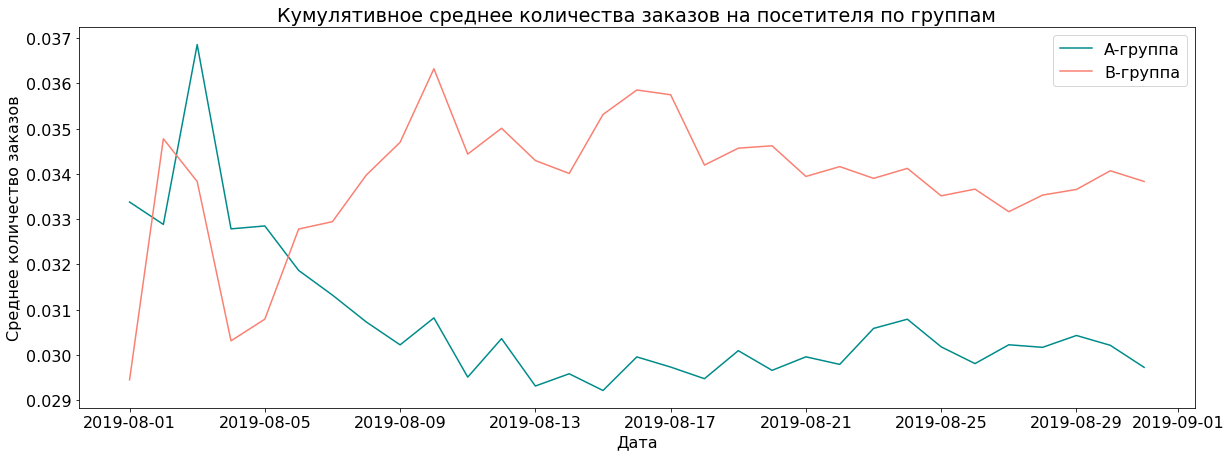

In [17]:
plt.figure(figsize=(20,7))
#зададим размер графика

plt.plot(cmltv_data_a['date'], cmltv_data_a['conversion'], label='A-группа', color = 'darkcyan')
plt.plot(cmltv_data_b['date'], cmltv_data_b['conversion'], label='B-группа', color = 'salmon')
#строим графики

plt.xlabel('Дата')
plt.ylabel ('Среднее количество заказов')
plt.title('Кумулятивное среднее количества заказов на посетителя по группам')
plt.legend();
#оформляем

**Вывод:** После 5 августа график становится практически симметричным, а ближе к концу августа даже более статичным. Несмотря на то, что в начале теста у группы A было самое большое значение конверсии за все время теста, в дальнейшем она продродолжала только снижаться. Конверсия у группы B после одного падения держится относительно стабильно.

### График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A

Для построения данного графика требуется объеденить кумулятивные данные с конверсией по группам:

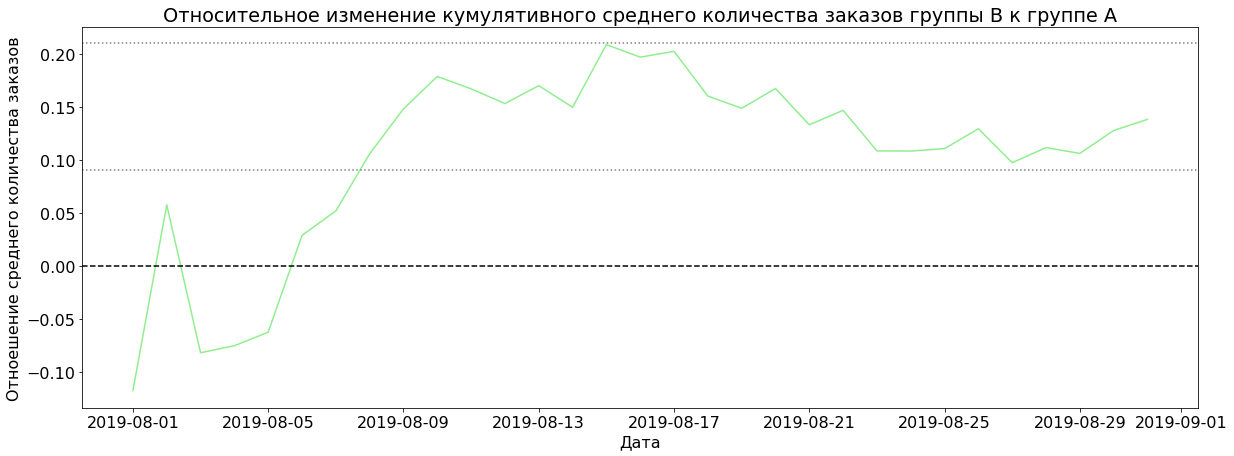

In [18]:
cmltv_conv = (cmltv_data_a[['date','conversion']]
            .merge(cmltv_data_b[['date','conversion']],\
            left_on='date', right_on='date', how='left', suffixes=['_a', '_b']))
#объединяем данные в одном датафрейме

plt.figure(figsize=(20,7))
#зададим размер графика

plt.plot(cmltv_conv['date'], cmltv_conv['conversion_b']/cmltv_conv['conversion_a']-1, color = 'lightgreen')
#строим график

plt.xlabel('Дата')
plt.ylabel ('Отноешение среднего количества заказов')
plt.title('Относительное изменение кумулятивного среднего количества заказов группы B к группе A')
#оформляем

plt.axhline(y=0.21, color='grey', linestyle=':')
plt.axhline(y=0.09, color='grey', linestyle=':')
plt.axhline(y=0, color='black', linestyle='--');
#добавляем горизонтальные оси

**Вывод:** В начале теста группа B значительно проигрывала группе A, затем вырвалась вперёд. Потом её конверсия снова падала, но после первой недели теста стала постепенно расти и с того момента держится на уровне от 9% до 21%.
В целом отношение конверсии ещё не установилось, и сейчас делать какие-либо выводы по тесту нельзя. Впрочем, сперва стоит проанализировать аномалии, возможно, они изменят картину. 

### Точечный график количества заказов по пользователям

Пользователи, совершившие много заказов, влияют на числитель формулы конверсии. Скорее всего, их поведение отличается от нормального. Если речь не идет об интернет-магазине с регулярным спросом, «обычный» пользователь совершает не больше двух заказов за короткий срок. 
Подсчитаем количество заказов по пользователям и посмотрим на результат:

In [19]:
users_orders = (
    orders.groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
)
#сгруппируем данные об уникальных заказах по пользователям 

users_orders.columns = ['user_id', 'orders']
#переименуем столбцы

users_orders.sort_values(by='orders', ascending=False).head(10)
#сортируем 

,user_id,orders
1023,4256040402,11
591,2458001652,11
569,2378935119,9
487,2038680547,8
44,199603092,5
744,3062433592,5
55,237748145,5
917,3803269165,5
299,1230306981,5
897,3717692402,5


Есть пользователи, которые совершали 5, 8, 9 и 11 заказов. Значительно больше, чем обычный пользователь за неделю. Построим точечный график количества заказов по пользователям:

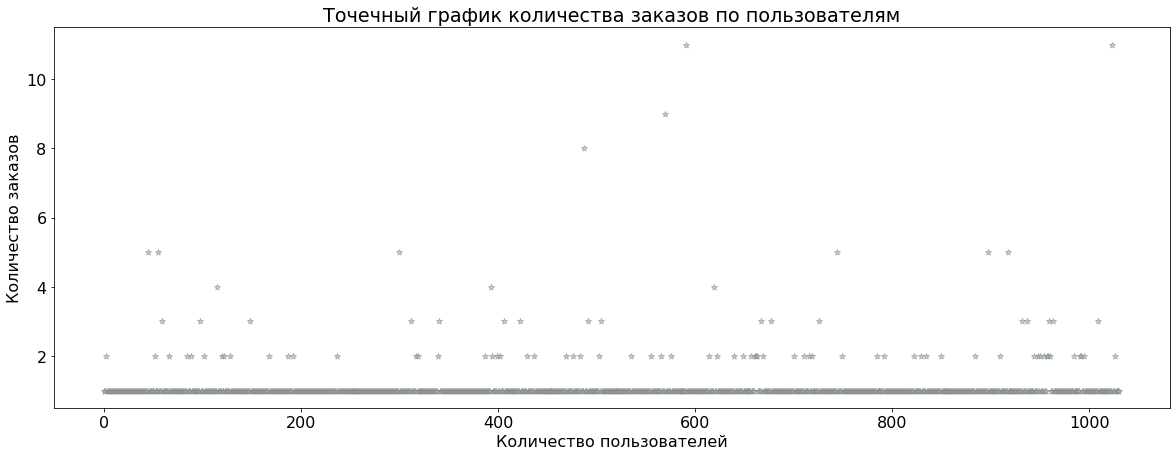

In [20]:
x_values = pd.Series(range(0,len(users_orders)))
#задаем значения оси x

plt.figure(figsize=(20,7))
#и размера графика

plt.scatter(x_values, users_orders['orders'], c='lightblue', alpha=0.6, marker ='*', edgecolor = 'grey')
#строим график

plt.xlabel('Количество пользователей')
plt.ylabel ('Количество заказов')
plt.title('Точечный график количества заказов по пользователям');
#оформляем

**Вывод**: Много пользователей с 2-5 заказами. Их точная доля не ясна — непонятно, считать их аномалиями или нет.
А вот заказы от 8 штук точно будут не учитываться в дальнейшем разборе.

### 95-й и 99-й перцентили количества заказов на пользователя

Посчитаем выборочные перцентили количества заказов на одного пользователя:

In [21]:
print(np.percentile(users_orders['orders'], [95, 99]))
#используем метод percentile()

[2. 4.]


**Вывод**: Не более 5% пользователей оформляли больше чем 2 заказов, и не более 1% - 4. 
Разумно выбрать 3 заказа на одного пользователя за верхнюю границу числа заказов, и отсеять аномальных пользователей по ней. 

### Точечный график стоимостей заказов

Так же как и слишком большое количество заказов, аномально дорогие заказы следует удалять из теста, для этого снова построим график:

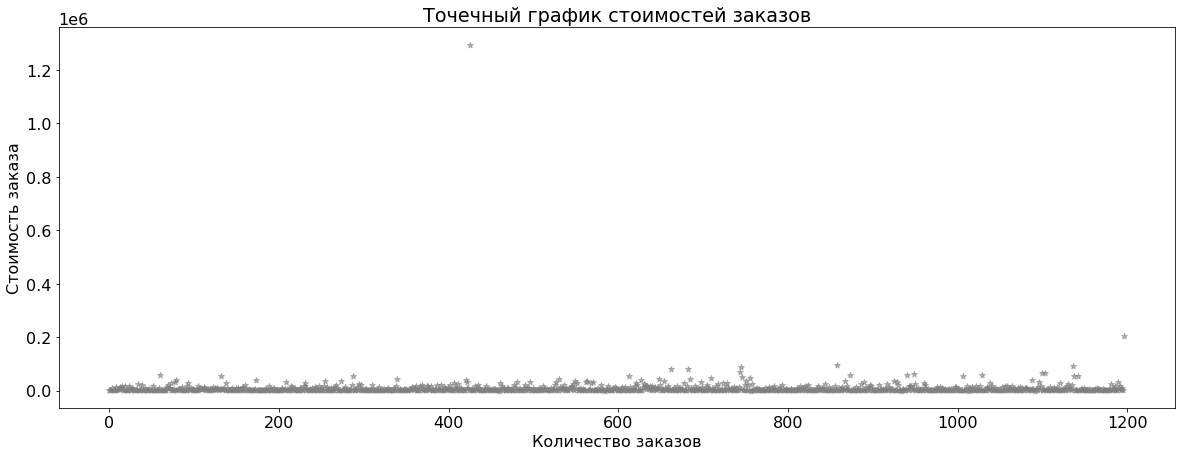

In [22]:
plt.figure(figsize=(20,7))
#зададим размер графика

x_values = pd.Series(range(0,len(orders['revenue'])))
#задаем значения оси x

plt.scatter(x_values, orders['revenue'], c='grey', alpha=0.6, marker ="*")
#строим график

plt.xlabel('Количество заказов')
plt.ylabel ('Стоимость заказа')
plt.title('Точечный график стоимостей заказов');
#оформляем

Основной массив данных находится в диапазоне до 0,1 млн. рублей, график сильно искажен из-за максимального значения, превыщающее отметку в 1,2 млн. рублей. Сделаем срез для наглядности:

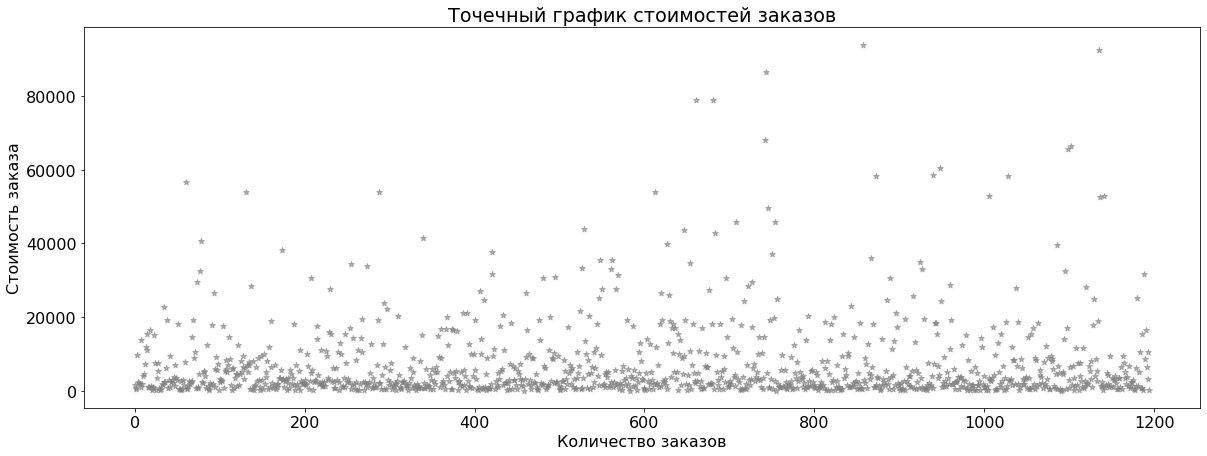

In [23]:
ord_q = orders.query('revenue < 100000')
#делаем срез до 100 000

plt.figure(figsize=(20,7))
#зададим размер графика

x_values = pd.Series(range(0,len(ord_q['revenue'])))
#задаем значения оси x

plt.scatter(x_values, ord_q['revenue'], c='grey', alpha=0.6, marker ="*")
#строим график

plt.xlabel('Количество заказов')
plt.ylabel ('Стоимость заказа')
plt.title('Точечный график стоимостей заказов');
#оформляем

**Вывод:** После среза данных до ста тысяч рублей, основной массив данных стал находиться в диапазоне до двадцати тысяч, но на основе графика не удается сделать вывод об аномальности значений, превыщающих это значение.

### 95-й и 99-й перцентили стоимости заказов

Для выявления аномальных значений отсеим от 1% до 5% наблюдений с крайними значениями стоимости заказов:

In [24]:
print(np.percentile(orders['revenue'], [95, 99]))
#используем метод percentile()

[28000.  58233.2]


**Вывод:** Не более 5% пользователей оформляли заказ на сумму более чем 28 000 рублей, и не более 1% - в районе 58 000 рублей. 
Разумно выбрать 30 000 рублей за верхнюю границу стоимости заказов, и отсеять аномальных пользователей по ней. 

### Cтатистическая значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным

После определения аномальных значений, мы можем оценить статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным и сравнить ее с "очищенными" данными. 
Для этого подготовим данные:

In [25]:
orders_users_a = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
#создаем переменную, где укажем число совершённых заказов в группе A, 
#для пользователей, которые заказывали хотя бы 1 раз

orders_users_a.columns = ['user_id', 'orders']
#переименовываем столбцы

orders_users_b = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
#создаем переменную, где укажем число совершённых заказов в группе B
#для пользователей, которые заказывали хотя бы 1 раз

orders_users_b.columns = ['user_id', 'orders']
#переименовываем столбцы

display(orders_users_a.head(5))
orders_users_b.head(5)
#посмотрим, что получилось

,user_id,orders
0,8300375,1
1,11685486,1
2,54447517,1
3,66685450,1
4,78758296,1


,user_id,orders
0,5114589,1
1,6958315,1
2,8300375,1
3,39475350,1
4,47206413,1


Теперь объявим переменные, в которых пользователям из разных групп будет соответствовать количество заказов. Тем, кто ничего не заказал, будут соответствовать нули. Это нужно, чтобы подготовить выборки к проверке критерием Манна-Уитни:

In [26]:
visitors_a = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitors_b = visitors[visitors['group'] == 'B'][['date', 'visitors']]
#сооздадим переменные с количеством пользователей в выбранную дату по группам

sample_a = pd.concat(
    [
        orders_users_a['orders'],
        pd.Series(
            0,
            index=np.arange(
                visitors_a['visitors'].sum() - len(orders_users_a['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sample_b = pd.concat(
    [
        orders_users_b['orders'],
        pd.Series(
            0,
            index=np.arange(
                visitors_b['visitors'].sum() - len(orders_users_b['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)
#создаем переменные, с количеством заказов по группам

Все готово для просчета статистической значимости различий в среднем количестве заказов на посетителя.

- Нулевая гипотеза: Статистически значимых различий в среднем числе заказов между группами нет
- Альтернативная: Различия есть
- Альфа-уровень проверки гипотезы возьмем равным 0.05

In [27]:
alpha = 0.05
#задаем значение альфа-уровня

p_value = stats.mannwhitneyu(sample_a, sample_b)[1]
#считаем значение p-value

print('p-value = {0:.3f}'.format(p_value))
#выводим значение p-value

print('Отношение конверсии В к А: {0:.3f}'.format(sample_b.mean() / sample_a.mean() - 1))
#выводим значение конверсии

if p_value < alpha:
    print('Статистически значимые различия в среднем числе заказов между группами существуют')
else:
    print('Статистически значимых различий в среднем числе заказов между группами нет')
#делаем сравнение и выводим гипотезу

p-value = 0.017
Отношение конверсии В к А: 0.138
Статистически значимые различия в среднем числе заказов между группами существуют


**Вывод:** По «сырым» данным различия в среднем числе заказов групп A и B существуют. 
P-value = 0.017, а значит меньше 0.05 и нулевую гипотезу о том, что статистически значимых различий в среднем числе заказов между группами нет, отвергаем. Однако относительный выигрыш группы B равен 13.8%.

### Статистическая значимость различий в среднем чеке заказа между группами по «сырым» данным

Теперь проверим статистическую значимость различий в среднем чеке между сегментами. 

- Нулевая гипотеза: Различий в среднем чеке между группами нет
- Альтернативная гипотеза: Различия в среднем чеке между группами есть
- Альфа-уровень проверки гипотезы возьмем равным 0.05

In [28]:
p_value = stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]
#считаем значение p-value

print('p-value = {0:.3f}'.format(p_value))
#выводим значение p-value

print('Отношение среднего чека группы B к группе A = {0:.3f}'.format(
    orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1)
     )
#выводим значение отношения средних чеков

if p_value < alpha:
    print('Статистически значимые различия в среднем чеке заказа между группами существуют')
else:
    print('Статистически значимых различий в среднем чеке заказа между группами нет')
#делаем сравнение и выводим гипотезу

p-value = 0.729
Отношение среднего чека группы B к группе A = 0.259
Статистически значимых различий в среднем чеке заказа между группами нет


**Вывод:** P-value значительно больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет, а отношение среднего чека группы B к чеку группы A имеет такое большое различие из-за единичных выбросов.

### Cтатистическая значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным

Напомним, что найденные ранее 95-й и 99-й перцентили средних чеков равны 28 000 и 58 233,2 рублям. А 95-й и 99-й перцентили количества заказов на одного пользователя равны 2 и 4 заказа на пользователя.
Примем за аномальных пользователей тех, кто совершил от 3 заказов или совершил заказ дороже 30 000 рублей. Так мы уберём 5% пользователей с наибольшим числом заказов и от 1% до 5% пользователей с дорогими заказами. 

Сделаем срезы пользователей с числом заказов больше 3 и пользователей, совершивших заказы дороже 30 000 и объединим их. Далее узнаем, сколько всего аномальных пользователей с помощью атрибута shape.

In [29]:
expensive_orders = orders[orders['revenue'] > 30000]['visitor_id']
#делаем срез по аномальной стоимости заказа

large_orders = pd.concat(
    [
        orders_users_a[orders_users_a['orders'] > 3]['user_id'],
        orders_users_b[orders_users_b['orders'] > 3]['user_id'],
    ],
    axis=0,
)
#делаем срез по аномальному количеству заказов по группам 

anomaly_users = (
    pd.concat([large_orders, expensive_orders], axis=0)
    .drop_duplicates()
    .sort_values()
)
#соединяем в один датафрейм

print('Количество аномальных пользователей составило', anomaly_users.shape[0], 'человек')
#выведем получившееся количество аномальных пользователей

anomaly_users.head()
#выводим первые 5 значений полученного датафрейма

Количество аномальных пользователей составило 57 человек


1099    148427295
18      199603092
928     204675465
23      237748145
684     358944393
dtype: int64

Всего 57 аномальных пользователей. Узнаем, как их действия повлияли на результаты теста. Посчитаем статистическую значимость различий в среднем количестве заказов между группами теста по очищенным данным. Сначала подготовим выборки количества заказов по пользователям по группам теста:

In [30]:
sample_a = pd.concat(
    [
        orders_users_a[
            np.logical_not(orders_users_a['user_id'].isin(anomaly_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                visitors_a['visitors'].sum() - len(orders_users_a['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sample_b = pd.concat(
    [
        orders_users_b[
            np.logical_not(orders_users_b['user_id'].isin(anomaly_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                visitors_b['visitors'].sum() - len(orders_users_b['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)
#создаем переменные, с количеством заказов по группам, не включающие аномальных пользователей

Все готово для просчета статистической значимости различий в среднем количестве заказов на посетителя.

Вспомним, что:
- Нулевая гипотеза: Статистически значимых различий в среднем числе заказов между группами нет
- Альтернативная: Различия есть
- Альфа-уровень проверки гипотезы возьмем равным 0.05

In [31]:
p_value = stats.mannwhitneyu(sample_a, sample_b)[1]
#считаем значение p-value

print('p-value = {0:.3f}'.format(p_value))
#выводим значение p-value

print('Отношение конверсии В к А: {0:.3f}'.format(sample_b.mean() / sample_a.mean() - 1))
#выводим значение конверсии

if p_value < alpha:
    print('Статистически значимые различия в среднем числе заказов между группами существуют')
else:
    print('Статистически значимых различий в среднем числе заказов между группами нет')
#делаем сравнение и выводим гипотезу

p-value = 0.018
Отношение конверсии В к А: 0.148
Статистически значимые различия в среднем числе заказов между группами существуют


**Вывод:** По «очищенным» данным, так же как и по "сырым" различия в среднем числе заказов групп A и B существуют. 
P-value = 0.018, и т.к. он незначительно отличается от предыдущего значения, значение так же меньше 0.05 и нулевую гипотезу о том, что статистически значимых различий в среднем числе заказов между группами нет, отвергаем. Однако относительный выигрыш группы B равен уже 14.8%.

### Статистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным

In [32]:
p_value = stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitor_id'].isin(anomaly_users)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitor_id'].isin(anomaly_users)),
                )
            ]['revenue'],
        )[1]
#считаем значение p-value для "очищенных" данных

print('p-value = {0:.3f}'.format(p_value))
#выводим значение p-value

print('Отношение среднего чека группы B к группе A = {0:.3f}'.format(
    orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitor_id'].isin(anomaly_users)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitor_id'].isin(anomaly_users)),
            )
        ]['revenue'].mean()
        - 1
    )
)
#выводим значение отношения "очищенных" средних чеков

if p_value < alpha:
    print('Статистически значимые различия в среднем чеке заказа между группами существуют')
else:
    print('Статистически значимых различий в среднем чеке заказа между группами нет')
#делаем сравнение и выводим гипотезу

p-value = 0.958
Отношение среднего чека группы B к группе A = -0.020
Статистически значимых различий в среднем чеке заказа между группами нет


**Вывод:** P-value так же значительно больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. Впрочем, средний чек группы B практически сравнялся со значением среднего чека группы A.

## Выводы

1) Есть статистически значимое различие по среднему количеству заказов между группами как по «сырым», так и по данным после фильтрации аномалий

2) Нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий

3) График различия среднего количества заказов между группами сообщает, что результаты группы B лучше группы A и довольно стабильно удерживает свои позиции

4) График различия среднего чека говорит о том, что результаты группы B 13 августа единственый раз ухудшаются по сравнению с группой A, исключая начало тестирования.

Исходя из обнаруженных фактов, тест следует остановить и признать его успешным. Продолжать смысла нет, потому как вероятность, что при имеющихся данных сегмент A спустя время станет лучше сегмента B — практически нулевая.